In [1]:
import pickle 
from data_loader import build_vocab, get_loader
from model import EncoderCNN, DecoderRNN 
from model import ResNet, ResidualBlock
from torch.autograd import Variable 
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import torch
import torch.nn as nn

root_path = './data/3object/'
batch_size= 64
num_workers = 8
vocab_path = 'data/vocab.pkl'
#vocab = build_vocab(root_path, threshold=0)
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
len_vocab = vocab.idx  

transform = transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize((0.033, 0.032, 0.033), 
                         (0.027, 0.027, 0.027))])

    
# Build data loader
data_loader = get_loader(root_path, vocab, 
                         transform, batch_size,                        
                         shuffle=True, num_workers=num_workers) 
#encoder = EncoderCNN(256)
encoder = ResNet(ResidualBlock, [3, 3, 3], len_vocab)
decoder = DecoderRNN(len_vocab, 256, 
                     len(vocab),1)

if torch.cuda.is_available():
    encoder.cuda(1)
    decoder.cuda(1)

In [2]:
import numpy as np
num_epochs = 5 
batch_size = 64
learning_rate = 0.001
log_step = 10
plot_every = 5 

all_losses =  [] 
all_accuarcy = [] 
all_exact_accuracy = []

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)


def rearrange_tensor(x, batch_size, caption_size):
    for i in range(caption_size):
        temp = x[i*batch_size:(i+1)*batch_size].view(batch_size, -1)
        if i == 0:
            temp_cat = temp 
        else: 
            temp_cat = torch.cat((temp_cat,  temp), 1)

    return temp_cat


def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda(1)
    return Variable(x, volatile=volatile)


total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(data_loader):
        
        # make one hot 
        cap_ = torch.unsqueeze(captions,2)
        one_hot_ = torch.FloatTensor(captions.size(0),captions.size(1),len_vocab).zero_()
        one_hot_caption = one_hot_.scatter_(2, cap_, 1)

        # Set mini-batch dataset
        images = to_var(images)  
        captions = to_var(captions)
        captions_ = to_var(one_hot_caption)
        #print(captions_)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]            
        # Forward, Backward and Optimize
        optimizer.zero_grad()
        features = encoder(images)
        outputs = decoder(features, captions_, lengths)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Print log info
        if i % log_step == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f'
                  %(epoch, num_epochs, i, total_step, 
                    loss.data[0], np.exp(loss.data[0]))) 
            
            outputs_np = outputs.max(1)[1].cpu().data.numpy()
            targets_np = targets.cpu().data.numpy()
            exact_match = 0 
            for i in range(len(targets_np)):
                if outputs_np[i] == targets_np[i]:
                        exact_match +=1 
 
            print('exact match accuracy: %.4f'
             %(exact_match/len(targets_np)))
            
            all_losses.append(loss.data[0])
            all_exact_accuracy.append(exact_match/len(targets_np))

                

Epoch [0/5], Step [0/157], Loss: 3.2528, Perplexity: 25.8617
exact match accuracy: 0.0359
Epoch [0/5], Step [10/157], Loss: 2.7013, Perplexity: 14.8992
exact match accuracy: 0.3255
Epoch [0/5], Step [20/157], Loss: 2.4862, Perplexity: 12.0158
exact match accuracy: 0.3211
Epoch [0/5], Step [30/157], Loss: 2.3599, Perplexity: 10.5894
exact match accuracy: 0.3338
Epoch [0/5], Step [40/157], Loss: 2.3002, Perplexity: 9.9763
exact match accuracy: 0.2855
Epoch [0/5], Step [50/157], Loss: 2.1560, Perplexity: 8.6363
exact match accuracy: 0.3432
Epoch [0/5], Step [60/157], Loss: 2.1101, Perplexity: 8.2491
exact match accuracy: 0.3711
Epoch [0/5], Step [70/157], Loss: 1.9486, Perplexity: 7.0191
exact match accuracy: 0.3848
Epoch [0/5], Step [80/157], Loss: 1.8159, Perplexity: 6.1468
exact match accuracy: 0.3804
Epoch [0/5], Step [90/157], Loss: 1.7765, Perplexity: 5.9094
exact match accuracy: 0.3768
Epoch [0/5], Step [100/157], Loss: 1.6165, Perplexity: 5.0352
exact match accuracy: 0.4127
Epoch 

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(1)
plt.plot(all_losses)

#plt.figure(2)
#plt.plot(all_accuarcy)

plt.figure(3)
plt.plot(all_exact_accuracy)



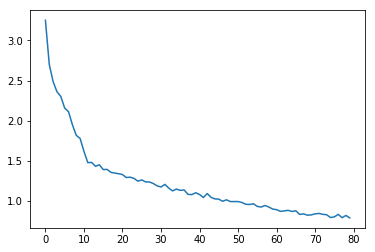

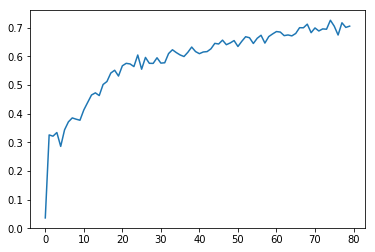

In [4]:
plt.show()